In [5]:
import getpass
import os

def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("OPENAI_API_KEY")

os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_API_KEY']="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"
os.environ['LANGCHAIN_PROJECT']="sql query agent"

In [6]:
from langsmith import utils

utils.tracing_is_enabled()

False

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri(f"sqlite:///db.sqlite3")
print(db.dialect)
print(db.get_usable_table_names())

sqlite
['auth_group', 'auth_group_permissions', 'auth_permission', 'auth_user', 'auth_user_groups', 'auth_user_user_permissions', 'budget_account', 'budget_transaction', 'django_admin_log', 'django_content_type', 'django_migrations', 'django_session']


In [8]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode


def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [4]:
from langchain_openai import ChatOpenAI
from langchain_community.chat_models import ChatZhipuAI

# chatAI = ChatZhipuAI(model="glm-4-flash")
chatAI = ChatOpenAI(base_url="https://api.deepseek.com", model="deepseek-chat")

In [5]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=chatAI)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))

print(get_schema_tool.invoke("budget_account"))

auth_group, auth_group_permissions, auth_permission, auth_user, auth_user_groups, auth_user_user_permissions, budget_account, budget_transaction, django_admin_log, django_content_type, django_migrations, django_session

CREATE TABLE budget_account (
	id INTEGER NOT NULL, 
	name VARCHAR(60) NOT NULL, 
	type VARCHAR(10) NOT NULL, 
	balance DECIMAL NOT NULL, 
	PRIMARY KEY (id)
)

/*
3 rows from budget_account table:
id	name	type	balance

*/


In [14]:
from langchain_core.tools import tool


@tool
def db_query_tool(query: str) -> str:
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result


print(db_query_tool.invoke("SELECT * FROM budget_transaction LIMIT 10;"))
print(db_query_tool.invoke("SELECT * FROM budget_account LIMIT 10;"))

[(1, '2025-02-13', 'Bank', 'Debit', 500, 5), (2, '2025-02-13', 'Rent', 'Credit', 500, 1), (3, '2025-02-13', 'Cash', 'Debit', 20, 3), (4, '2025-02-13', 'Food', 'Credit', 20, 4), (5, '2023-10-06', 'Bank', 'debit', 25, 3), (6, '2023-10-06', 'Bank', 'debit', 25, 3)]
[(1, 'Bank', 'ASSET', 4500), (2, 'Transportation', 'EXPENSE', 0), (3, 'Food', 'EXPENSE', 70), (4, 'Cash', 'ASSET', 480), (5, 'Rent', 'EXPENSE', 500)]


In [8]:
from langchain_core.prompts import ChatPromptTemplate

query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system), ("placeholder", "{messages}")]
)
query_check = query_check_prompt | chatAI.bind_tools(
    [db_query_tool], tool_choice="required"
)

query_check.invoke({"messages": [("user", "SELECT * FROM Account LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0_9e35b760-fce2-4a55-97a2-02bc5f1ff7d5', 'function': {'arguments': '{"query":"SELECT * FROM Account LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 278, 'total_tokens': 305, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 256}, 'prompt_cache_hit_tokens': 256, 'prompt_cache_miss_tokens': 22}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_3a5770e1b4', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96e54c65-236e-4d68-a5a2-f9efdca87bf1-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Account LIMIT 10;'}, 'id': 'call_0_9e35b760-fce2-4a55-97a2-02bc5f1ff7d5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 278, 'output_tokens': 27, 'total_tokens': 305, 'input_token_details': {'cache_read': 256}, 'outp

In [9]:
from typing import Annotated, Literal

from langchain_core.messages import AIMessage

from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages


# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


# Define a new graph
workflow = StateGraph(State)


# Add a node for the first tool call
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",
                        "args": {},
                        "id": "tool_abcd123",
                    }
                ],
            )
        ]
    }


def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}


workflow.add_node("first_tool_call", first_tool_call)

# Add nodes for the first two tools
workflow.add_node(
    "list_tables_tool", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = chatAI.bind_tools(
    [get_schema_tool]
)
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.

Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.

When generating the query:

Output the SQL query that answers the input question without a tool call.

Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.

If you get an error while executing a query, rewrite the query and try again.

If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database."""
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | chatAI.bind_tools(
    [SubmitFinalAnswer]
)


def query_gen_node(state: State):
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer":
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []
    return {"messages": [message] + tool_messages}


workflow.add_node("query_gen", query_gen_node)

# Add a node for the model to check the query before executing it
workflow.add_node("correct_query", model_check_query)

# Add node for executing the query
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))


# Define a conditional edge to decide whether to continue or end the workflow
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        return END
    if last_message.content.startswith("Error:"):
        return "query_gen"
    else:
        return "correct_query"


# Specify the edges between the nodes
workflow.add_edge(START, "first_tool_call")
workflow.add_edge("first_tool_call", "list_tables_tool")
workflow.add_edge("list_tables_tool", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("correct_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Compile the workflow into a runnable
app = workflow.compile()

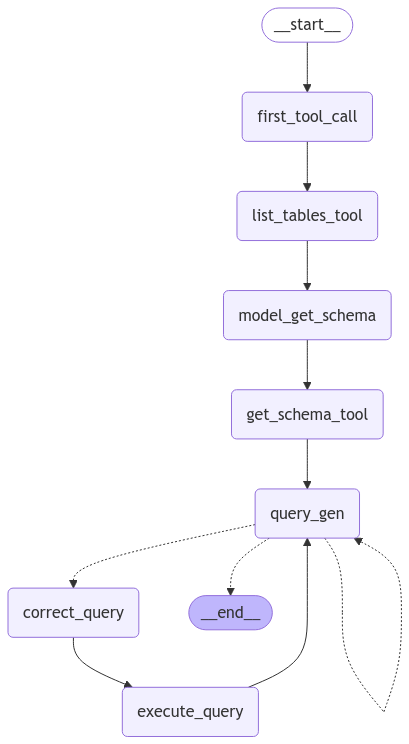

In [10]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [11]:
messages = app.invoke(
    {"messages": [("user", "What is the total balance all the asset accounts?")]}
)
json_str = messages["messages"][-1].tool_calls[0]["args"]["final_answer"]
json_str

'The total balance of all asset accounts is 1000.00.'